In [1]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models

%matplotlib inline

# Import data

In [2]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

p = PuuOo(eruption_csv_path)
time, lat, lon, depth, mag = load_puuoo_eqs(eq_csv_path)
print(time[1], depth.shape)

1983-01-01 00:43:33 (6485,)


### Remove eqs that happened before eruption history


In [3]:
from itertools import compress

def prune_data(time, lat, lon, depth, mag, puuoo):
    """
    Prune data by removing all eqs that happened before eruption catalogue starts
    WARNING: be careful with datatypes (assumes you want list for time and numpy array for other vars)
    """

    idx = [puuoo.was_erupting(t) is not None for t in time]
    
    time  = list(compress(time, idx))
    lat   = np.array(list(compress(lat, idx)))
    lon   = np.array(list(compress(lon, idx)))
    depth = np.array(list(compress(depth, idx)))
    mag   = np.array(list(compress(mag, idx)))
    
    return time, lat, lon, depth, mag

In [4]:
time, lat, lon, depth, mag = prune_data(time, lat, lon, depth, mag, p)
erupt = [p.was_erupting(t) for t in time]

print(len(time))
print(len(erupt))
print(erupt[:40])
print(any(erupt[:40]))

6485
6485
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
False


In [5]:
print(time[0], ',', time[-1])
tmp = np.unique(time)
print(len(tmp))

1983-01-01 00:18:51 , 1986-12-30 21:57:33
6485


### Get earthquake counts per year/month/week/day. 

In [6]:
# obtain days since beginning year of catalog
# gather up the years

Years = np.array([time[ti].year for ti in range(len(time))])
Nyears = np.unique(Years)

t0 = datetime.datetime(Years[0],1,1,0,0,0)
print(t0)

DaysSinceCatStart = [(time[ti] - t0).days for ti in range(len(time))]
print(DaysSinceCatStart[:100])
print(len(DaysSinceCatStart), DaysSinceCatStart[-1])

1983-01-01 00:00:00
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
6485 1459


In [7]:
# gather up features: earthquakes per day and maximum magnitude as inputs for logistic regression

EQsPerDay = np.zeros(DaysSinceCatStart[-1])
Eruption  = np.zeros(DaysSinceCatStart[-1])
MaxMag    = np.zeros(DaysSinceCatStart[-1])

for di in range(len(EQsPerDay)):
    EQsPerDay[di] = DaysSinceCatStart.count(di)
    
    if EQsPerDay[di]>0:
        indices      = [i for i in range(len(DaysSinceCatStart)) if DaysSinceCatStart[i] == di] 
        Eruption[di] = any([p.was_erupting(time[ti]) for ti in indices])
        MaxMag[di]   = mag[indices].max()
        

print(EQsPerDay[:100])
print(Eruption[:100])
print(MaxMag[:100])


[ 11.  77.  98.  29.  26.  24. 100.  32.  15.  10.   5.  11.  10.  10.
  10.  10.   5.   3.  12.  12.   8.   3.  12.   6.  10.   3.   6.   7.
   1.   2.   5.   4.   7.   4.   4.   1.   2.   4.   6.   4.   5.   6.
   8.   2.   1.   5.   3.   7.   1.   4.   4.   3.   2.   2.   2.   3.
   1.   4.   2.   3.   2.   5.   5.  11.   2.   2.   4.   3.   6.   3.
   2.   1.   1.   2.   6.   2.   4.   6.   5.  15.   3.   0.   6.   6.
   2.   8.   0.   1.   1.   4.   2.   8.   2.   3.   1.   0.   9.   2.
   0.   7.]
[0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0.]
[2.6  3.15 3.94 2.86 3.85 2.46 2.81 2.8  1.97 2.55 1.92 2.02 2.89 2.81
 2.06 4.06 2.19 2.92 2.8  2.53 3.   2.42 3.59 4.47 3.36 2.38 3.46 2.52
 1.59 1.59 2.32 2.69 2.95 3.51 2.45 2.08 2.

1459 1459


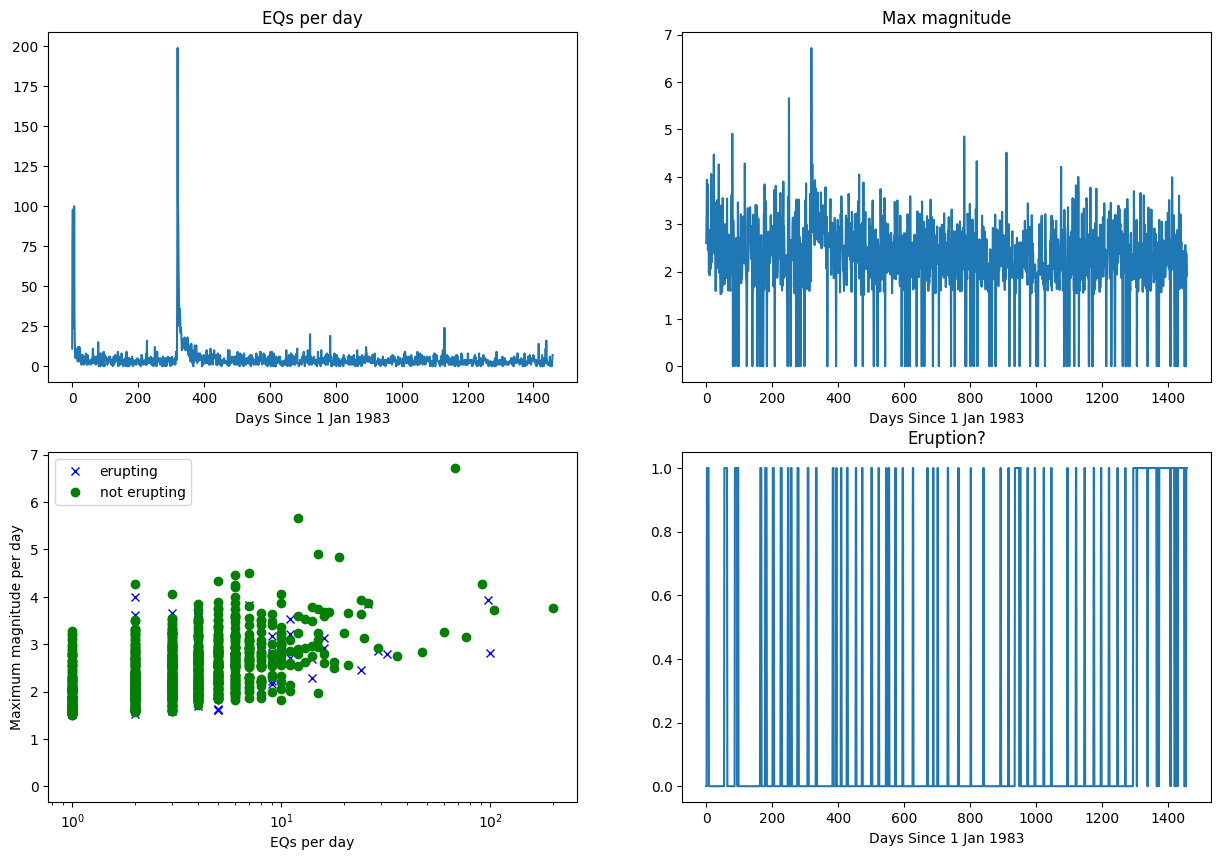

In [8]:
Days = np.arange(0,DaysSinceCatStart[-1])
print(len(Days), len(EQsPerDay))

# plot features and labels in time
plt.figure(figsize=(15,10))
ax1 = plt.subplot(221)
plt.plot(Days, EQsPerDay)
plt.title('EQs per day')
plt.xlabel('Days Since 1 Jan 1983')

ax1 = plt.subplot(222)
plt.plot(Days, MaxMag)
plt.title('Max magnitude')
plt.xlabel('Days Since 1 Jan 1983')

ax1 = plt.subplot(223)
plt.semilogx(EQsPerDay[Eruption==1], MaxMag[Eruption==1], 'bx', label='erupting')
plt.semilogx(EQsPerDay[Eruption==0], MaxMag[Eruption==0], 'go', label='not erupting')
plt.xlabel('EQs per day')
plt.ylabel('Maximum magnitude per day')
plt.legend()

ax1 = plt.subplot(224)
plt.plot(Days, Eruption)
plt.title('Eruption?')
plt.xlabel('Days Since 1 Jan 1983')
plt.savefig('EQrates_maxmag_time.png')


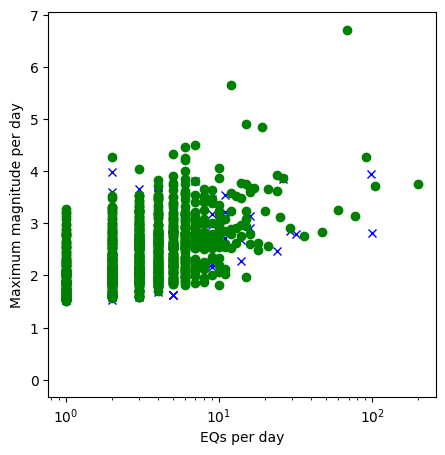

In [9]:

plt.figure(figsize=(5,5))
plt.semilogx(EQsPerDay[Eruption==1], MaxMag[Eruption==1], 'bx')
plt.semilogx(EQsPerDay[Eruption==0], MaxMag[Eruption==0], 'go')
plt.xlabel('EQs per day')
plt.ylabel('Maximum magnitude per day')
plt.savefig('EQrates_maxmag.png')


In [10]:
from sklearn.linear_model import LogisticRegression

npEQs = np.array(EQsPerDay).reshape((len(EQsPerDay),1))

X = np.concatenate((np.ones((len(EQsPerDay),1)), npEQs, MaxMag.reshape((len(MaxMag),1))), axis=1)
print(X.shape)

y = np.copy(Eruption)

lr = LogisticRegression(random_state=0,solver='lbfgs').fit(X, y)
yhat = lr.predict(X)

print(np.all(yhat==0))
print(1/len(y)*np.sum(1-y))

lr.score(X,y)

(1459, 3)
True
0.8032899246058945


0.8032899246058944

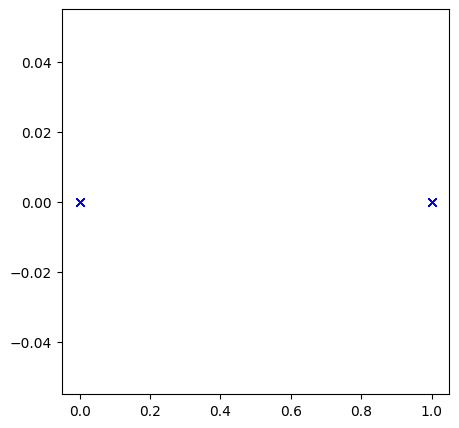

In [11]:
plt.figure(figsize=(5,5))
plt.plot(y,yhat, 'bx')
plt.show()